In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy.signal as sps
import exoplanet as ex
from tessifystarspot import *
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

In [2]:
def gausssmooth(time, flux, kern):
    """Takes a time series and applies a Gaussian filter,
         removing edge effects.
      time: ndarray, 1D
      flux: ndarray, 1D
      kern: gaussian smoothing
    """

    gauss_flux = convolve(flux, Gaussian1DKernel(kern), boundary='extend')

    flux2 = flux - gauss_flux

    return flux2, gauss_flux # correct, fit

def polysmooth(time, flux, degree):
    """Takes a time series and fits a polynomial
      of input degree, then divides by polynomial.
    """

    pfit = np.polyfit(time, flux, degree)
    fit = np.poly1d(pfit)
    xfit = np.linspace(min(time), max(time), len(time))

    flux2 = flux / fit(xfit)

    return flux2, fit, xfit

In [2]:
time = np.arange(0,27,1/24/2)
flux = np.sin(time/4) # * np.cos(time/2)
lc = lk.LightCurve(time=time, flux=flux)

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

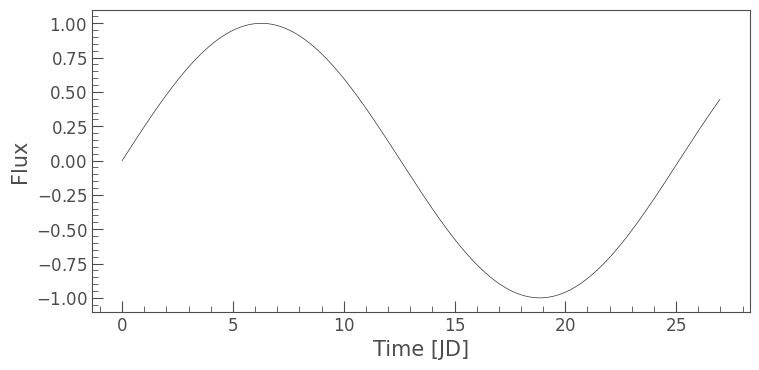

In [4]:
lc.plot()

In [5]:
tess_cadence = 1/24/2
tess_sf = 1/(30*60)
print(lc.to_periodogram().period_at_max_power.value, acf_rotation(lc, tess_sf))

26.979166666666664 18.355


In [6]:
# scipy butterworth filter
sos = sps.butter(3, 1/(15*86400), 'hp', fs=tess_sf, output='sos') #(1/15)/86400
newflux = sps.sosfilt(sos, lc.flux.value)
lc_new = lk.LightCurve(time=time, flux=newflux)

<IPython.core.display.Javascript object>


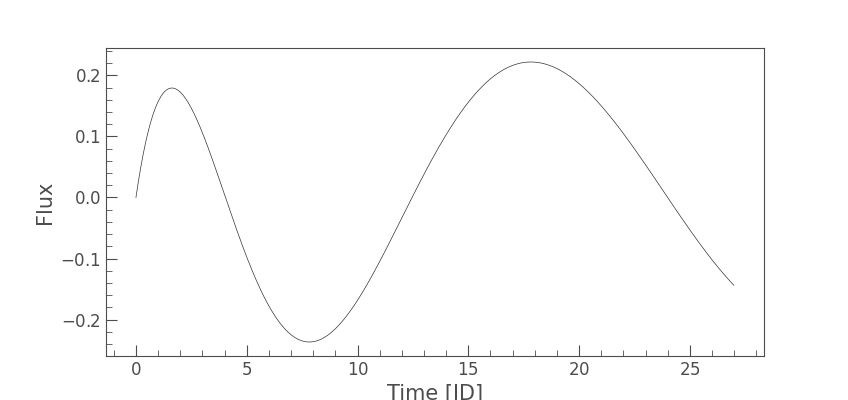

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

In [71]:
%matplotlib notebook
lc_new.plot()

In [50]:
def sos_solver(sos, time):
    A = sos[0]
    B = sos[1]
    A1 = A[0] + A[1]*np.power(time,-1) + A[2]*np.power(time,-2)
    A2 = A[3] + A[4]*np.power(time,-1) + A[5]*np.power(time,-2)
    B1 = B[0] + B[1]*np.power(time,-1) + B[2]*np.power(time,-2)
    B2 = B[3] + B[4]*np.power(time,-1) + B[5]*np.power(time,-2)
    return (A1/A2)*(B1/B2)

<ipython-input-50-b00b518583ce>:4: RuntimeWarning: divide by zero encountered in power
  A1 = A[0] + A[1]*np.power(time,-1) + A[2]*np.power(time,-2)
<ipython-input-50-b00b518583ce>:4: RuntimeWarning: invalid value encountered in multiply
  A1 = A[0] + A[1]*np.power(time,-1) + A[2]*np.power(time,-2)
<ipython-input-50-b00b518583ce>:5: RuntimeWarning: divide by zero encountered in power
  A2 = A[3] + A[4]*np.power(time,-1) + A[5]*np.power(time,-2)
<ipython-input-50-b00b518583ce>:5: RuntimeWarning: invalid value encountered in multiply
  A2 = A[3] + A[4]*np.power(time,-1) + A[5]*np.power(time,-2)
<ipython-input-50-b00b518583ce>:6: RuntimeWarning: divide by zero encountered in power
  B1 = B[0] + B[1]*np.power(time,-1) + B[2]*np.power(time,-2)
<ipython-input-50-b00b518583ce>:6: RuntimeWarning: invalid value encountered in add
  B1 = B[0] + B[1]*np.power(time,-1) + B[2]*np.power(time,-2)
<ipython-input-50-b00b518583ce>:7: RuntimeWarning: divide by zero encountered in power
  B2 = B[3] + B[4]

<IPython.core.display.Javascript object>


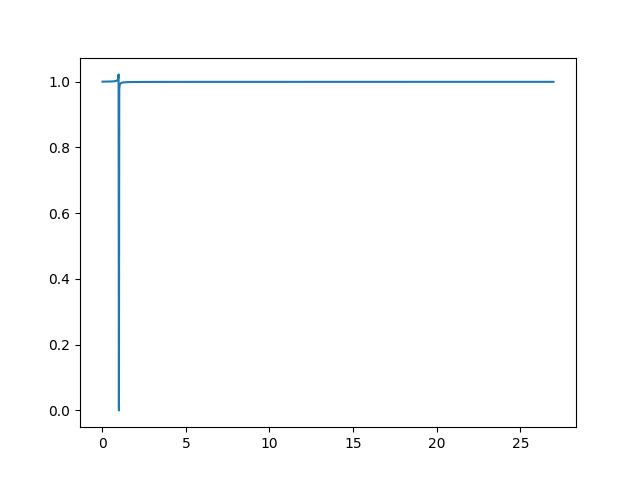

In [56]:
y = sos_solver(sos, lc.time.value)

%matplotlib notebook
plt.figure(1)
plt.plot(lc.time.value, y)

In [103]:
# gaussian
newflux, fit = gausssmooth(lc.time, lc.flux, 100)
lc_new = lk.LightCurve(time=time, flux=newflux)

In [10]:
print(lc_new.to_periodogram().period_at_max_power.value, acf_rotation(lc_new, tess_cadence))

26.99972222222222 18.541666666666664


In [10]:
lc_real = lk.search_lightcurve('KIC 1865663', quarter=9).download().remove_outliers()
# lc_real = lk.search_lightcurve('KIC 1026146', quarter=9).download().remove_outliers()

In [21]:
lc_real = lc_real.normalize() - 1

/home/isy/aur/miniconda3/lib/python3.8/site-packages/lightkurve/lightcurve.py:965: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


<IPython.core.display.Javascript object>


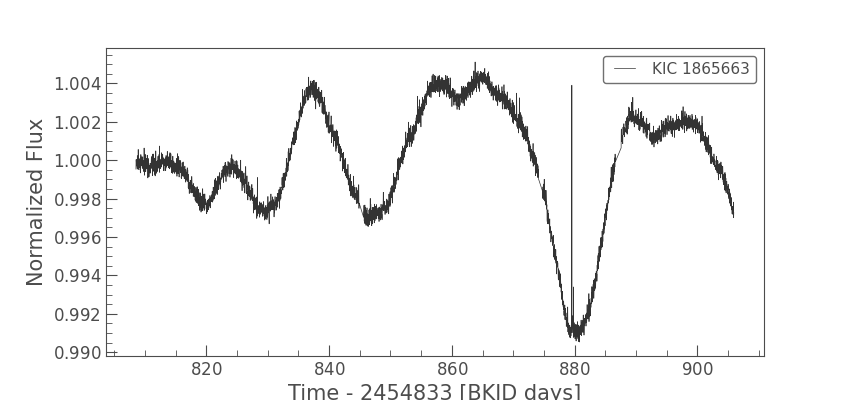

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

In [16]:
lc_real.plot()

In [22]:
# butterworth
# sos = sps.butter(3, (1/15)/86400, 'hp', fs=tess_sf, output='sos') #(1/15)/84600
sos = sps.butter(3, (1/15), 'hp', fs=48, output='sos') #(1/15)/84600
newflux = sps.sosfilt(sos, lc_real.flux.value, axis=0)
lc_real2 = lk.LightCurve(time=lc_real.time, flux=newflux)

<IPython.core.display.Javascript object>


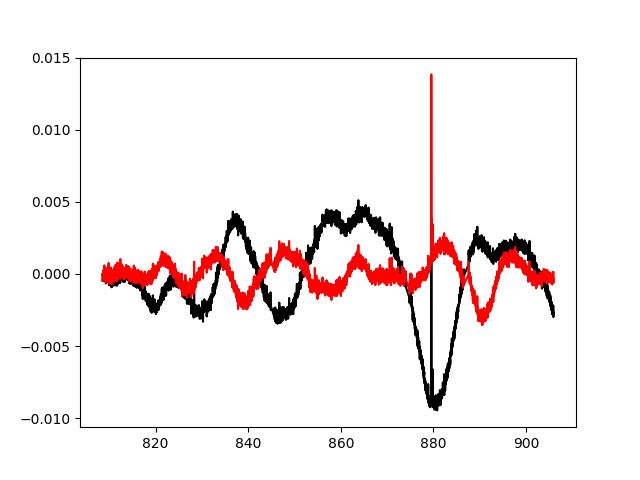

In [25]:
%matplotlib notebook
# lc_real2.plot()
plt.plot(lc_real.time.value, lc_real.flux.value, 'k-')
plt.plot(lc_real2.time.value, lc_real2.flux.value, 'r-')

In [127]:
# gaussian
newflux, fit = gausssmooth(lc_real.time, lc_real.flux, 100)
lc_real2 = lk.LightCurve(time=lc_real.time, flux=newflux)

<IPython.core.display.Javascript object>


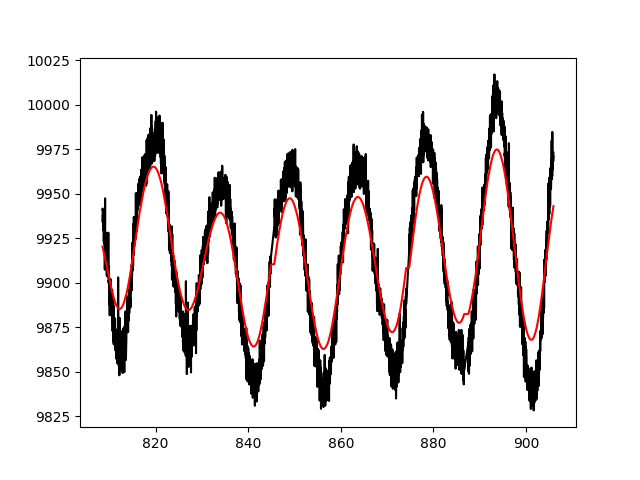

In [128]:
fig, ax = plt.subplots(1)
ax.plot(lc_real.time.value, lc_real.flux.value, 'k-')
ax.plot(lc_real.time.value, fit, 'r-')